## MODELS
- Go to import dataset; the steps below are preprocessing of the data.

In [1]:
from collections import Counter
from datetime import datetime

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import json
import numpy as np
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


In [2]:
y_review = '/Users/Kenneth S. Hansen/Desktop/yelp/dataset/review.json'
#y_business = '/Users/Kenneth S. Hansen/Desktop/yelp/dataset/business.json'

In [3]:
def yelp_data_generator(file_path):
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            # yield the the data line-by-line
            yield json.loads(line.rstrip())

In [4]:
# create generator object
reviews = yelp_data_generator(y_review)
#business = yelp_data_generator(y_business)

In [5]:
# converting generator object to data frame
t1 = datetime.now()
df_reviews = pd.DataFrame.from_records(reviews, coerce_float=True, exclude=['review_id','user_id','date'])
print(datetime.now() - t1)

0:01:55.800990


In [ ]:
t1 = datetime.now()
df_business = pd.DataFrame.from_records(business, coerce_float=True, exclude=['name','neighborhood','address','city',
                                                                             'latitude', 'longitude',
                                                                             'stars', 'review_count', 'is_open',
                                                                             'attributes', 'categories', 'hours'])
print(datetime.now() - t1)

In [ ]:
from bs4 import BeautifulSoup
import requests

response = requests.get('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States').text
soup = BeautifulSoup(response, 'html.parser')

In [ ]:
states = []

table = soup.find('table', class_='wikitable')

for row in table.find_all('tr')[2:]:
    st = row.find_all('td')[0]
    states.append(st.text)

print(states)

list_ = list(states)

In [ ]:
len(list_)

In [ ]:
df_business_us = df_business.loc[ df_business.state.isin(list_), : ]
df_business_us.shape

In [ ]:
df_final = pd.merge(df_business_us, df_reviews, on='business_id')
df_final.shape

### IMPORT dataset
- The dataset is merged and filtered for non-us countries

In [ ]:
import pandas as pd
df_final = pd.read_csv('/Users/Kenneth S. Hansen/Desktop/yelp/dataset_final/df_final.csv', encoding='ISO-8859-1')

In [ ]:
df_final.shape

### Downsampling - Binary Classification

In [ ]:
#Get a balanced sample of positive and negative reviews
texts = [review for review in df_final['text']]

# Based on the stars, I split the reviews into positive or negative
#stars_y is from our review dataset, which I want to split on.

binstars = [0 if review <= 3 else 1 for review in df_final['stars']]
balanced_texts = []
balanced_labels = []
limit = 100000 # Change this to grow/shrink the dataset. In this case, I'm taking 100.000 positive and negative each.
neg_pos_counts = [0, 0]
for i in range(len(texts)):
    polarity = binstars[i]
    if neg_pos_counts[polarity] < limit:
        balanced_texts.append(texts[i])
        balanced_labels.append(binstars[i])
        neg_pos_counts[polarity] += 1

In [ ]:
from collections import Counter
print(Counter(balanced_labels))

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=300)

### Binary Classification

In line two, we add an Embedding layer. This layer lets the network expand each token to a larger vector, allowing the network to represent words in a meaningful way. We pass 20000 as the first argument, which is the size of our vocabulary (remember, we told the tokenizer to only use the 20 000 most common words earlier), and 128 as the second, which means that each token can be expanded to a vector of size 128. We give it an input_length of 300, which is the length of each of our sequences.

In [ ]:
#CNN
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, CSVLogger, History

#saving performance to log for visualization
filepath="imp-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('binary_cnn_training_history.csv')
history = History()
callbacks_list = [checkpoint, history, csv_logger]


model = Sequential()
model.add(Embedding(20000, 300, input_length=300))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(300)) #128 before
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
binary_cnn = model.fit(data, np.array(balanced_labels), validation_split=0.3, epochs=10, callbacks=callbacks_list)

### Visualization of the performance

In [ ]:
hist = pd.read_csv('/Users/Kenneth S. Hansen/desktop/yelp/Yelp_models/binary_cnn/binary_cnn_training_history.csv')
hist = hist.drop('epoch', axis=1)
plt.figure(figsize=(13,6))
hist.plot(figsize=(13,6))
plt.title('Neural Network for Sentiment Classification ')
plt.show()

### Save model for later use

In [ ]:
import pickle

#save the tokenizer and model
with open('keras_tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f) #tokenizer = the tokenized text above
    
binary_cnn.model.save('binary_yelp_sentiment_model') #name of the dave model

If we want to predict whether some new piece of text is positive or negative, we can load our model and get a prediction with:

#### importing model and tokenized data

In [ ]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
 
# load the tokenizer and the model
with open("keras_tokenizer.pickle", "rb") as f:
   tk = pickle.load(f)

model = load_model('binary_yelp_sentiment_model')

In [ ]:
# replace with sentences that you want to classify
newtexts = ["I loved the food! It was awesome", "The service was of good quality"]

In [ ]:
# RECALL that we should NOT call "fit" on the tokenizer again
sequences = tk.texts_to_sequences(newtexts)
data = pad_sequences(sequences, maxlen=300)

In [ ]:
# Get predictions for each of your new texts
# Observe that the first sentence is negative and classified 
predictions = model.predict(data)
print(predictions)

## Recommender system

In [ ]:
def sentiment_predictor(input_, rating):
    sequences = tk.texts_to_sequences(input_)
  
    padded_sequences = pad_sequences(sequences, maxlen = 300) #padding = 'post')

    preds = model.predict(padded_sequences)

    #average
    predicted_rating = np.ndarray.round(preds[0])

    print(input_)
    print(rating)
    print(predicted_rating)
    if rating == 1 and preds < 0.5:
        print('Are you sure about that score? It seems like you hated it')
    elif rating == 0 and preds >= 0.5:
        print("Hmm, it seems like you really like this place, are you sure about that rating?")

In [ ]:
input_ = ['Probably the worst and most horrible place i have ever visited']
rating = 1

sentiment_predictor(input_, rating)

## Predidting the star rating - Multinominal classification

#### Importing the dataset reviews

In [1]:

import json
 
# read the data from disk and split into lines
# we use .strip() to remove the final (empty) line
with open('/Users/Kenneth S. Hansen/Desktop/yelp/dataset/review.json', encoding='utf-8') as f:
    reviews = f.read().strip().split("\n")
 
# each line of the file is a separate JSON object
reviews = [json.loads(review) for review in reviews] 
 
# we're interested in the text of each review 
# and the stars rating, so we load these into 
# separate lists
texts = [review['text'] for review in reviews]
stars = [review['stars'] for review in reviews]

In [8]:
texts = df_reviews['text'].tolist()
stars = df_reviews['stars'].tolist()

In [9]:
print(len(texts))
print(len(stars))

4736897
4736897


#### Balancing the data into equal sizes of 1-5 rating reviews

In [10]:
from collections import Counter
 
def balance_classes(xs, ys):
    freqs = Counter(ys)
    max_allowable = 100000 #freqs.most_common()[-1][1] #Taking the lowest sample of the stars, and ensure downsampling
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [11]:
#Confirm that the sampling occured succesfully - first line = the original allocaiton of star in the dataset
#the second line shows the allocation of reviews when downsampled
print(Counter(stars))
balanced_x, balanced_y = balance_classes(texts, stars)
print(Counter(balanced_y))

Counter({5: 1988003, 4: 1135830, 1: 639849, 3: 570819, 2: 402396})
Counter({5: 100000, 3: 100000, 4: 100000, 1: 100000, 2: 100000})


#### Tokenizing the data

In [12]:
tokenizer = Tokenizer(num_words=20000) #currently only using the 20000 most common words #Increae? The average
tokenizer.fit_on_texts(balanced_x)
sequences = tokenizer.texts_to_sequences(balanced_x)
data = pad_sequences(sequences, maxlen=300) #Average length 600

In [13]:
len(data)

500000

#### Dummy encoding dependent variable - requried

In [14]:
### Dummy encode the target variable
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(balanced_y)
encoded_Y = encoder.transform(balanced_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [15]:
len(dummy_y)

500000

#### Spliting into train and validate

In [16]:
# 70-30 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, dummy_y, test_size=0.3, random_state=9)

### Multiple classification - CNN

In [20]:
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, CSVLogger, History

In [ ]:
#CNN using Keras' own embedding
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, CSVLogger, History

#saving performance to log for visualization
filepath="imp-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('multiple_class_keras_training_history.csv')
history = History()
callbacks_list = [checkpoint, history, csv_logger]


model = Sequential()
model.add(Embedding(20000, 300, input_length=300))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(300)) #128 before
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#The model ran for 17 hours
multiple_keras = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks_list)

In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

#### Confusion matrix - with prediction

In [35]:
import seaborn as sns
import pandas_ml as pdml
from pandas_ml import ConfusionMatrix 
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
import seaborn as sns
import pandas_ml as pdml
from pandas_ml import ConfusionMatrix 
from matplotlib import pyplot as plt
import numpy as np

y_true = y_test.argmax(axis=1)
preds = model.predict_classes(X_test)

cm = ConfusionMatrix(y_true, preds)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))
plt.show()
# cm.classification_report

In [ ]:
from sklearn.metrics import confusion_matrix
cm.classification_report

In [ ]:
print(confusion_matrix(y_true, preds))

##### Saving the model for later use
- Saving the model enables me to not train then entire model again (saving a LOT of time)

In [ ]:
#Saving the CNN model
# serialize model to JSON
model_json = model.to_json()
with open("/Users/Kenneth S. Hansen/desktop/Yelp_models/cnn_model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/Users/Kenneth S. Hansen/desktop/Yelp_models/cnn_model2.h5")
print("Saved model to disk")

#### Loading the model

In [ ]:
C:\Users\Kenneth S. Hansen\Desktop\yelp\Yelp_models\cnn_multi_keras_emb

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open("/Users/Kenneth S. Hansen/Desktop/yelp/Yelp_models/cnn_multi_keras_emb/cnn_model2.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/Users/Kenneth S. Hansen/Desktop/yelp/Yelp_models/cnn_multi_keras_emb/cnn_model2.h5")
print("Loaded model from disk")
from keras.models import model_from_json
# load json and create model
json_file = open("/Users/Kenneth S. Hansen/Desktop/yelp/Yelp_models/cnn_multi_keras_emb/cnn_model2.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/Users/Kenneth S. Hansen/Desktop/yelp/Yelp_models/cnn_multi_keras_emb/cnn_model2.h5")
print("Loaded model from disk")

In [ ]:
# evaluate the loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)) 

### Visualization of the CNN model performance - based on the log

In [ ]:
hist = pd.read_csv('/Users/Kenneth S. Hansen/desktop/Yelp_models/keras_training_history.csv')
hist = hist.drop('epoch', axis=1)
plt.figure(figsize=(13,6))
hist.plot(figsize=(13,6))
plt.title('Neural Network for Sentiment Classification ')
plt.show()

### Visualization in 2-dimensional space

In [ ]:
import keras.backend as K

def get_features_for_layer(X, trained_model, layer_number, batches=256):
    """
    :param X: Batch with dimensions according to the models first layer input-shape
    :param trained_model: Model to extract data from
    :param layer_number: Index of the layer we want to extract features from.
    :param batches: If set it will call the function in batches to save (gpu)memory
    :return: 
    """
    get_features = K.function([trained_model.layers[0].input, K.learning_phase()],
                              [trained_model.layers[layer_number].output])
    
    if batches:
        g = array_batch_yield(X, batches)
        features = []
        for batch in g:
            feature_batch = get_features([batch, 0])
            features.append(feature_batch)
            
        features = np.concatenate(features, axis=1)[0]
        
    else:
        features = get_features([X, 0])

    return features

def array_batch_yield(X, group_size):
    for i in range(0, len(X), group_size):
        yield X[i:i+group_size]

In [ ]:
#Extracting the recurrent LSTM layer below (layer 4)
print(features_gru.shape) #Correspond to the training data (350.000 reviews), 128word vectors(dimensions)
model.layers

### Visualization of the worst performing model

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Extracting LSTM layer with 128 word vectors (dimensions) for each review in X_train(350.000)
features_gru = get_features_for_layer(X_train, model, 4, batches=500)

tsne = TSNE()

pca = PCA(n_components=2)

f_gru_pca = pca.fit_transform(features_gru)


p = Pipeline([
        ('pca', pca), 
#         ('tsne', tsne)
    ])
feat = p.fit_transform(features_gru[:10000])

df = pd.DataFrame(feat)
df.columns = ['v1','v2']
df['stars'] = y_train.argmax(axis=1)[:10000].astype(str)
sns.lmplot('v1','v2', data=df, hue='stars', fit_reg=False,  scatter_kws={'alpha':0.5}, size=12)
plt.title('PCA from LSTM layer')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

### Visualization of the best performing model

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Extracting LSTM layer with 128 word vectors (dimensions) for each review in X_train(350.000)
features_gru = get_features_for_layer(X_train, model, 4, batches=500)

tsne = TSNE()

pca = PCA(n_components=2)

f_gru_pca = pca.fit_transform(features_gru)


p = Pipeline([
        ('pca', pca), 
#         ('tsne', tsne)
    ])
feat = p.fit_transform(features_gru[:10000])

df = pd.DataFrame(feat)
df.columns = ['v1','v2']
df['stars'] = y_train.argmax(axis=1)[:10000].astype(str)
sns.lmplot('v1','v2', data=df, hue='stars', fit_reg=False,  scatter_kws={'alpha':0.5}, size=12)
plt.title('PCA from LSTM layer')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [ ]:
features_gru = get_features_for_layer(X_train, model, 4, batches=500)

In [ ]:
features_gru.shapec

#### Fitting cnn with the built-in function - Validation is 50% of the data.
- Here, we pass in our padded, tokenized texts as the first argument, and the labels as the second argument. We use validation_split=0.5 to tell our neural network that it should take half of the data to learn from, and that it should test itself on the other half. This means it will take half the reviews, along with their labels, and try to find patterns in the tokens that represent positive or negative labels. It will then try to predict the answers for the other half, without looking at the labels, and compare these predictions to the real labels, to see how good the patterns it learned are.

#### CNN WITHOUT spliting train and test. Instead validation on 50% Multiple classification

In [ ]:
#Do NOT run this again - took approximately 6 hours
multiple_cnn = model.fit(data, dummy_y, validation_split=0.5, epochs=10, callbacks=callbacks_list)

The score may seem a bit low, but we need to keep in mind that with five rating classes, random guessing would be correctly only 20% of the time

#### Saving the cnn model


In [ ]:
#Saving the CNN model
# serialize model to JSON
model_json = model.to_json()
with open("/Users/Kenneth S. Hansen/desktop/Yelp_models/cnn_model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/Users/Kenneth S. Hansen/desktop/Yelp_models/cnn_model1.h5")
print("Saved model to disk")

#### Loading in the cnn model

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open("/Users/Kenneth S. Hansen/desktop/Yelp_models/cnn_model1.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/Users/Kenneth S. Hansen/desktop/Yelp_models/cnn_model1.h5")
print("Loaded model from disk")

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

### OWN TRAINED WORD2VEC - CNN

### Binary Classification - own trained word2vec embedding

In [ ]:
np.random.seed(0)
BASE_DIR = ''
W2V_DIR = '/Users/Kenneth S. Hansen/desktop/yelp/Yelp_models/word2vec300.txt'
MAX_SEQUENCE_LENGTH = 300 #600 gives an error
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
PRELOAD = True

####
def load_w2v_into_dict(w2v_path):
    """
    :param w2v_path: strpath
  
    """
    embeddings_ix = {}
    with open(w2v_path) as w2v_file:
        for line in w2v_file:
            val = line.split()
            word = val[0]
            vec = np.asarray(val[1:], dtype='float32')
            embeddings_ix[word] = vec
    return embeddings_ix

###
import operator
WORD_INDEX_SORTED = sorted(tokenizer.word_index.items(), key=operator.itemgetter(1))

###
embedding_index = load_w2v_into_dict(W2V_DIR)
nb_words = min(MAX_NB_WORDS, len(WORD_INDEX_SORTED))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

###

In [ ]:
from keras.utils.np_utils import to_categorical

#saving performance to log for visualization
filepath="imp-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('binary_own_embedding_training_history.csv')
history = History()
callbacks_list = [checkpoint, history, csv_logger]



model = Sequential()
#model.add(Embedding(20000, 128, input_length=300))
model.add(Embedding(input_dim=nb_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Fitting the model

In [ ]:
binary_cnn_own_emb = model.fit(data, np.array(balanced_labels), validation_split=0.3, epochs=10, callbacks=callbacks_list)

#### Saving the model

In [ ]:
import pickle

#save the tokenizer and model
with open('keras_tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f) #tokenizer = the tokenized text above
    
binary_cnn_own_emb.model.save('binary_cnn_own_yelp_sentiment_model') #name of the dave model

#### Visualization of the performance

In [ ]:
hist = pd.read_csv('/Users/Kenneth S. Hansen/desktop/binary_own_embedding_training_history.csv')
hist = hist.drop('epoch', axis=1)
plt.figure(figsize=(13,6))
hist.plot(figsize=(13,6))
plt.title('Neural Network for Sentiment Classification ')
plt.show()

### Multinominal classification - own trained word2vec embedding

In [18]:
len(embedding_matrix)

20000

In [17]:
np.random.seed(0)
BASE_DIR = ''
W2V_DIR = '/Users/Kenneth S. Hansen/desktop/yelp/Yelp_models/word2vec300.txt'
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
PRELOAD = True

####
def load_w2v_into_dict(w2v_path):
    """
    :param w2v_path: strpath
  
    """
    embeddings_ix = {}
    with open(w2v_path) as w2v_file:
        for line in w2v_file:
            val = line.split()
            word = val[0]
            vec = np.asarray(val[1:], dtype='float32')
            embeddings_ix[word] = vec
    return embeddings_ix

###
import operator
WORD_INDEX_SORTED = sorted(tokenizer.word_index.items(), key=operator.itemgetter(1))

###
embedding_index = load_w2v_into_dict(W2V_DIR)
nb_words = min(MAX_NB_WORDS, len(WORD_INDEX_SORTED))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

###

In [25]:
from keras.utils.np_utils import to_categorical

#saving performance to log for visualization
filepath="imp-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('multipleclass_own_embedding_training_history.csv')
history = History()
callbacks_list = [checkpoint, history, csv_logger]

model = Sequential()
#model.add(Embedding(20000, 128, input_length=300))
model.add(Embedding(input_dim=nb_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

##### Fitting the model

In [26]:
multiple_own_emb = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks_list)

Train on 350000 samples, validate on 150000 samples
Epoch 1/10
350000/350000 [==============================] - 3678s - loss: 0.9485 - acc: 0.5836 - val_loss: 0.8935 - val_acc: 0.6075
Epoch 2/10
350000/350000 [==============================] - 3597s - loss: 0.8990 - acc: 0.6052 - val_loss: 0.8890 - val_acc: 0.6115
Epoch 3/10
350000/350000 [==============================] - 3555s - loss: 0.8856 - acc: 0.6118 - val_loss: 0.8781 - val_acc: 0.6162
Epoch 4/10
350000/350000 [==============================] - 3548s - loss: 0.8795 - acc: 0.6144 - val_loss: 0.8742 - val_acc: 0.6180
Epoch 5/10
350000/350000 [==============================] - 3547s - loss: 0.8751 - acc: 0.6172 - val_loss: 0.8783 - val_acc: 0.6157
Epoch 6/10
350000/350000 [==============================] - 3546s - loss: 0.8715 - acc: 0.6185 - val_loss: 0.8717 - val_acc: 0.6197
Epoch 7/10
350000/350000 [==============================] - 3549s - loss: 0.8697 - acc: 0.6195 - val_loss: 0.8714 - val_acc: 0.6200
Epoch 8/10
350000/350000

In [31]:
multiple_own_emb.model.predict_proba(X_test)

150000/150000 [==============================] - 989s   


array([[  5.74972391e-01,   2.65437663e-01,   1.04902931e-01,
          3.65879312e-02,   1.80990938e-02],
       [  1.40917793e-01,   5.01271427e-01,   2.85158098e-01,
          5.51784560e-02,   1.74742006e-02],
       [  7.80646563e-01,   1.43324405e-01,   4.14699875e-02,
          1.41938571e-02,   2.03651395e-02],
       ..., 
       [  1.26599204e-02,   5.38751595e-02,   3.60400558e-01,
          4.73985344e-01,   9.90790352e-02],
       [  1.48387032e-03,   7.43175372e-02,   7.56560624e-01,
          1.61826581e-01,   5.81146544e-03],
       [  7.92205334e-03,   3.05139095e-01,   6.56624794e-01,
          2.96547748e-02,   6.59266021e-04]], dtype=float32)

#### Visualization of the performance

In [29]:
from matplotlib import pyplot as plt

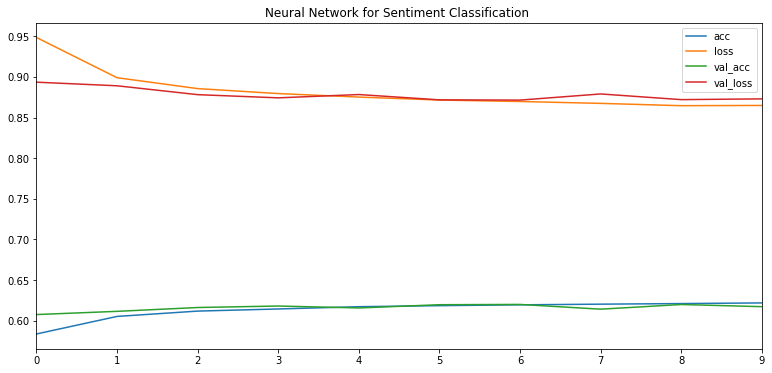

In [30]:
hist = pd.read_csv('/Users/Kenneth S. Hansen/desktop/multipleclass_own_embedding_training_history.csv')
hist = hist.drop('epoch', axis=1)
plt.figure(figsize=(13,6))
hist.plot(figsize=(13,6))
plt.title('Neural Network for Sentiment Classification ')
plt.show()

#### Confusion matrix
- Requires test data

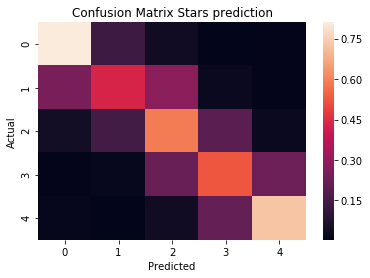

In [47]:
#y_true = y_test.argmax(axis=1)
#preds = multiple_own_emb.model.predict_classes(X_test)

cm = ConfusionMatrix(y_true, preds)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))
# cm.classification_report
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
cm.classification_reportfication_report

,precision,recall,F1_score,support
Classes,,,,
0,0.719376,0.810044,0.762023,30007
1,0.586495,0.433857,0.49876,29890
2,0.501237,0.588196,0.541246,29973
3,0.548538,0.525664,0.536857,30120
4,0.726707,0.727991,0.727348,30010
__avg / total__,0.616471,0.617233,0.613297,150000
